In [26]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import numpy as np
from math import ceil, floor

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import cv2

import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
%ls /gdrive/MyDrive/Colab\ Notebooks/ML\ ciencias\ da\ vida/processed/

no/  yes/


In [4]:
path = "/gdrive/MyDrive/Colab Notebooks/ML ciencias da vida/processed"

In [5]:
brain_tumor_n = []
brain_tumor_y = []

folder = f"{path}/no"
with os.scandir(folder) as images:
    for i, image in enumerate(images):
        img = cv2.imread(f"{folder}/{image.name}", 0)
        if image.name.endswith('.jpg'):
            brain_tumor_n.append(img)
        
folder = f"{path}/yes"
with os.scandir(folder) as images:
    for i, image in enumerate(images):
        img = cv2.imread(f"{folder}/{image.name}", 0)
        if image.name.endswith('.jpg'):
            brain_tumor_y.append(img)

In [6]:
n_no = len(brain_tumor_n)
n_yes = len(brain_tumor_y) 
w, h = brain_tumor_n[0].shape

# une imagens
flatten_n = np.array(brain_tumor_n).reshape(n_no, w * h)
flatten_y = np.array(brain_tumor_y).reshape(n_yes, w * h)
X = np.concatenate((flatten_n,  flatten_y ))

#recupera targets
# 0 -> sem tumor, 1 -> com tumor
y = np.concatenate( (np.zeros(n_no), np.ones(n_yes) ), axis=0)
assert(y.shape[0] == X.shape[0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

In [8]:
X_train.shape

(126, 22500)

In [9]:
pca = PCA(n_components = 0.7, whiten = True)
pca.fit(X_train)
projected = pca.fit_transform(X_test)
projected.shape

(127, 25)

In [30]:
parameters = {'svc__kernel':('linear', 'rbf'), 'svc__C':[1, 10, 100],
              'svc__gamma': ['scale', 1e-3, 1e-4]}

pca = PCA(n_components=0.7, whiten = True)
svc = svm.SVC()
pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

clf = GridSearchCV(pipe, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.7, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_

In [31]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Grid scores on development set:

0.714 (+/-0.107) for {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
0.746 (+/-0.107) for {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
0.714 (+/-0.107) for {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
0.627 (+/-0.033) for {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.714 (+/-0.107) for {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
0.627 (+/-0.033) for {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.699 (+/-0.103) for {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
0.817 (+/-0.066) for {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
0.699 (+/-0.103) for {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
0.675 (+/-0.075) for {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.699 (+/-0.103) for {'svc__C': 10, 'svc__gamma': 

Confusion matrix:
[[0.70588235 0.29411765]
 [0.25       0.75      ]]


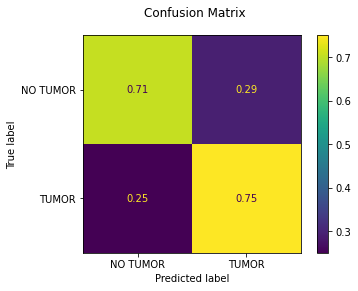

In [32]:
class_names = ['NO TUMOR', 'TUMOR']
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names,
                             normalize='true')
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Proporcionalmente, o modelo errou mais classificando "sem tumor" como "tumor", tendo então mais falsos positivos